# Calibration

** ** 

### To use the NaI scintilator to measure gamma-ray energies, a calibration curve needs to be generated by comparing the distribution of the measured gamma peaks from different sources with known spectra of the same elements.  

 * This project uses the lmfit package. Lmfit provides curve fiting using non-linear least squares minimization and was developed by Matt Newville: https://github.com/newville.

## Install and import libraries

In [1]:
#uncomment the following line to install lmfit
#!pip install lmfit

In [2]:
#import libraries
from numpy import sqrt, pi, exp, linspace, loadtxt
from lmfit.models import PolynomialModel
import matplotlib.pyplot as plt
import pylab as pl
import numpy as np
import matplotlib.lines as mlines
import pandas as pd
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

## Data Wrangling

In [3]:
# Load the data
x = np.array([14.4136, 80.998, 122.060, 160.605, 356.005, 511.006, 661.6570, 1274.54])
y = np.array([29.3812658, 70.4034958, 100.839961, 102.324468, 254.677094, 350.450834, 638.540552, 738.972592])
yerr = np.array([0.18549652, 0.17173121, 0.01380636, 0.91631394, 0.56142631, 0.16202290, 0.28312335, 0.70087825])

In [4]:
#use builtin NameModel, specify prefix for each:
mod1 = PolynomialModel(1, prefix='p1_')
mod2 = PolynomialModel(2, prefix='p2_')

In [5]:
#set initial parameters
pars1 = mod1.guess(y, x=x)
pars2 = mod2.guess(y, x=x)                     

In [6]:
#fit 
result1 = mod1.fit(y, pars1, x=x, weights = 1. / (y * np.mean(yerr / y) + y * 0.155))
result2 = mod2.fit(y, pars2, x=x, weights = 1. / (y * np.mean(yerr / y) + y * 0.17))

#print the Fit Statistics and parameters
print('------------------------------------------------------')
print(result1.fit_report())
print('------------------------------------------------------')
print(result2.fit_report())
print('------------------------------------------------------')

------------------------------------------------------
[[Model]]
    Model(polynomial, prefix='p1_')
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 8
    # variables        = 2
    chi-square         = 6.04366262
    reduced chi-square = 1.00727710
    Akaike info crit   = 1.75654945
    Bayesian info crit = 1.91543253
    R-squared          = 0.99998826
[[Variables]]
    p1_c0:  19.5815269 +/- 4.60864878 (23.54%) (init = 40.46435)
    p1_c1:  0.63055858 +/- 0.04966391 (7.88%) (init = 0.6166929)
[[Correlations]] (unreported correlations are < 0.100)
    C(p1_c0, p1_c1) = -0.5040
------------------------------------------------------
[[Model]]
    Model(polynomial, prefix='p2_')
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 9
    # data points      = 8
    # variables        = 3
    chi-square         = 5.02095416
    reduced chi-square = 1.00419083
    Akaike info crit   = 2.27342757
    Bayesian in

## Plot the models

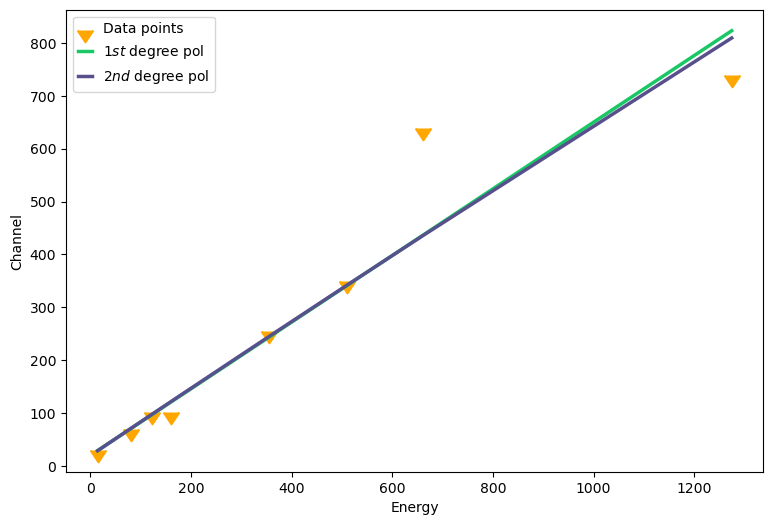

In [7]:
#%matplotlib widget

plt.figure(figsize=(9,6))

plt.rcParams['legend.handlelength'] = 1
plt.rcParams['legend.numpoints'] = 1
plt.scatter(x, y, marker=11, c='#ffa600', s=128)
plt.plot(x, result1.best_fit, '#19c865', linewidth=2.5)
plt.plot(x, result2.best_fit, '#58508d', linewidth=2.5)


plt.ylabel('Channel')
plt.xlabel('Energy')
#plt.title('')
plt.legend(('Data points', '$1st$ degree pol', '$2nd$ degree pol'),loc='best')

#plt.yscale('log')
plt.show()

In [8]:
print('-------------------------------')
print('Parameter    Value       Stderr')
for name, param in result2.params.items():
    print(f'{name:7s} {param.value:11.5f} {param.stderr:11.5f}')

-------------------------------
Parameter    Value       Stderr
p2_c0      19.25000     5.59542
p2_c1       0.64062     0.09163
p2_c2      -0.00002     0.00012


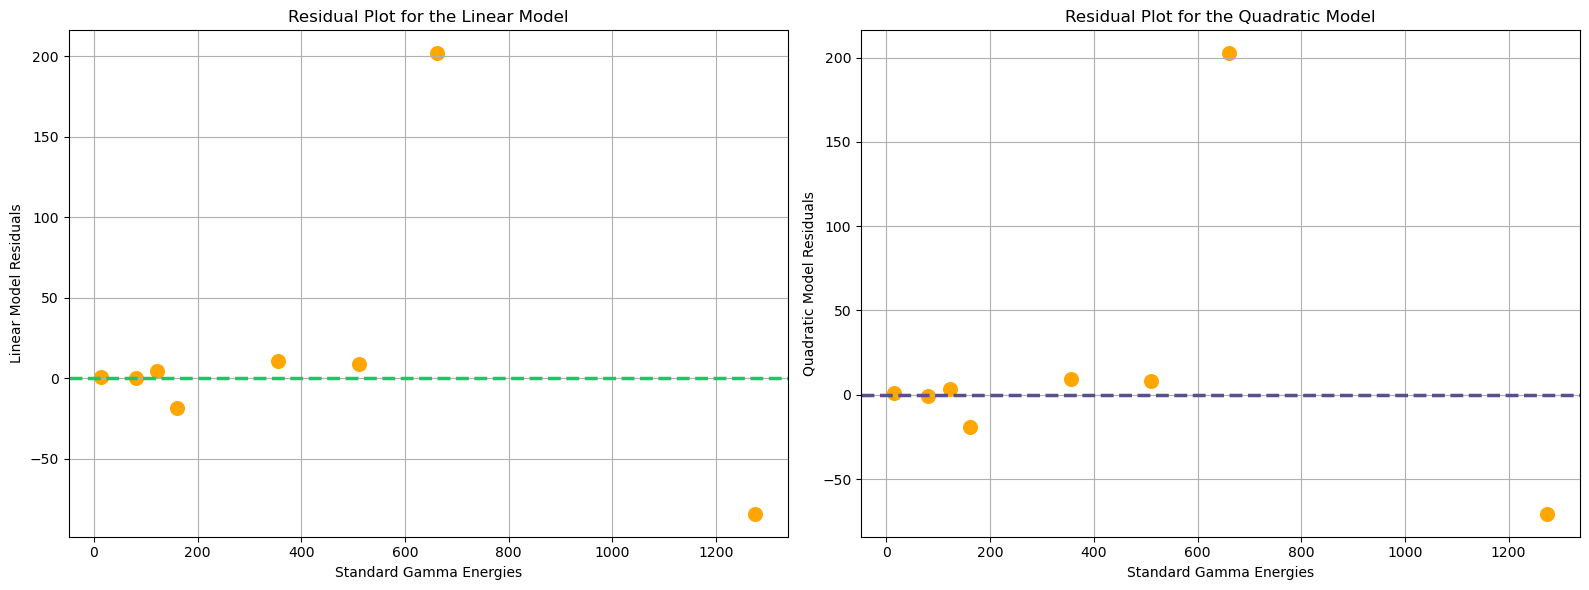

In [9]:
# Calculate residuals
pol1_residuals = y - result1.eval()
pol2_residuals = y - result2.eval()

# Create a 2x2 subplot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

# Plot the calibration curve
ax1 = axes[0]
ax1.scatter(x, pol1_residuals, color='#ffa600', s=96)
ax1.axhline(y=0, color='#19c865', linestyle='--', linewidth=2.5)
ax1.set_xlabel('Standard Gamma Energies')
ax1.set_ylabel('Linear Model Residuals')
ax1.set_title('Residual Plot for the Linear Model')
ax1.grid(True)
ax1.grid(True)

# Plot residuals
ax2 = axes[1]
ax2.scatter(x, pol2_residuals, color='#ffa600', s=96)
ax2.axhline(y=0, color='#58508d', linestyle='--', linewidth=2.5)
ax2.set_xlabel('Standard Gamma Energies')
ax2.set_ylabel('Quadratic Model Residuals')
ax2.set_title('Residual Plot for the Quadratic Model')
ax2.grid(True)

plt.tight_layout()
plt.show()

## Repeat the analysis by flipping the axis

The most common way to create a calibration curve is to model the instrument response on the y-axis. This approach is based on the assumption that the standard values have smaller uncertainties.

In the current project we need the calibration function to predict energy values based on instrument response at different scattering angles.

In [10]:
#Reverse the mapping
x_r = np.array([29.3812658, 70.4034958, 100.839961, 102.324468, 254.677094, 350.450834, 638.540552, 738.972592])
y_r = np.array([14.4136, 80.998, 122.060, 160.605, 356.005, 511.006, 661.6570, 1274.54])
yerr_r = np.array([0.0003, 0.008, 0.010, 0.015, 0.017, 0.008, 0.003, 0.008])

In [11]:
#use builtin NameModel, specify prefix for each:
mod_r1 = PolynomialModel(1, prefix='p_r1_')
mod_r2 = PolynomialModel(2, prefix='p_r2_')

In [12]:
#set initial parameters
pars_r1 = mod_r1.guess(y_r, x=x_r)
pars_r2 = mod_r2.guess(y_r, x=x_r)    

In [13]:
#fit with weights=1./yerr
result_r1 = mod_r1.fit(y_r, pars_r1, x=x_r, weights = 1. / (y_r * np.mean(yerr_r / y_r) + y_r * 0.198))
result_r2 = mod_r2.fit(y_r, pars_r2, x=x_r, weights = 1. / (y_r * np.mean(yerr_r / y_r) + y_r * 0.186))

#print the Fit Statistics and parameters
print('------------------------------------------------------')
print(result_r1.fit_report())
print('------------------------------------------------------')
print(result_r2.fit_report())
print('------------------------------------------------------')

------------------------------------------------------
[[Model]]
    Model(polynomial, prefix='p_r1_')
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 8
    # variables        = 2
    chi-square         = 6.02310344
    reduced chi-square = 1.00385057
    Akaike info crit   = 1.72928885
    Bayesian info crit = 1.88817194
    R-squared          = 0.99999511
[[Variables]]
    p_r1_c0: -27.7098961 +/- 4.87254145 (17.58%) (init = -24.02699)
    p_r1_c1:  1.45191439 +/- 0.12099408 (8.33%) (init = 1.475987)
[[Correlations]] (unreported correlations are < 0.100)
    C(p_r1_c0, p_r1_c1) = -0.8209
------------------------------------------------------
[[Model]]
    Model(polynomial, prefix='p_r2_')
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 9
    # data points      = 8
    # variables        = 3
    chi-square         = 5.02055530
    reduced chi-square = 1.00411106
    Akaike info crit   = 2.27279203
   

## Plot the models

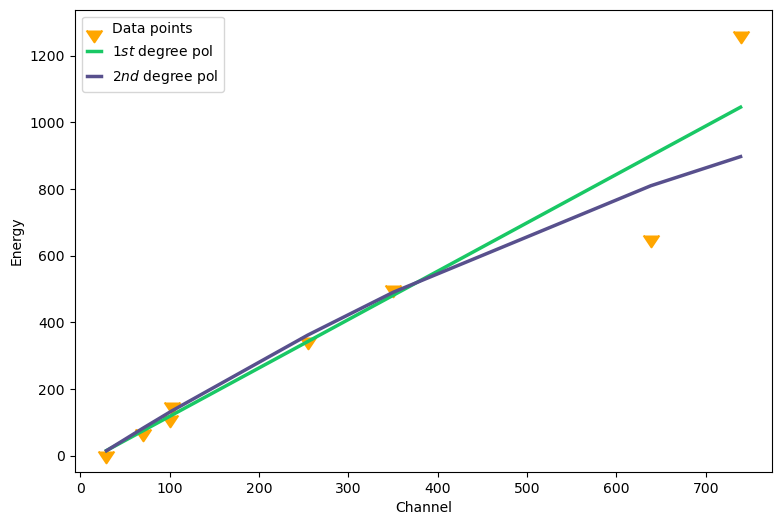

In [14]:
#%matplotlib widget

plt.figure(figsize=(9,6))

plt.rcParams['legend.handlelength'] = 1
plt.rcParams['legend.numpoints'] = 1
plt.scatter(x_r, y_r, marker=11, c='#ffa600', s=128)
plt.plot(x_r, result_r1.best_fit, '#19c865', linewidth=2.5)
plt.plot(x_r, result_r2.best_fit, '#58508d', linewidth=2.5)


plt.ylabel('Energy')
plt.xlabel('Channel')
#plt.title('')
plt.legend(('Data points', '$1st$ degree pol', '$2nd$ degree pol'),loc='best')

#plt.yscale('log')
plt.show()

In [15]:
print('-------------------------------')
print('Parameter    Value       Stderr')
for name, param in result_r2.params.items():
    print(f'{name:7s} {param.value:11.5f} {param.stderr:11.5f}')

-------------------------------
Parameter    Value       Stderr
p_r2_c0   -35.38041     7.32770
p_r2_c1     1.71396     0.22612
p_r2_c2    -0.00061     0.00046


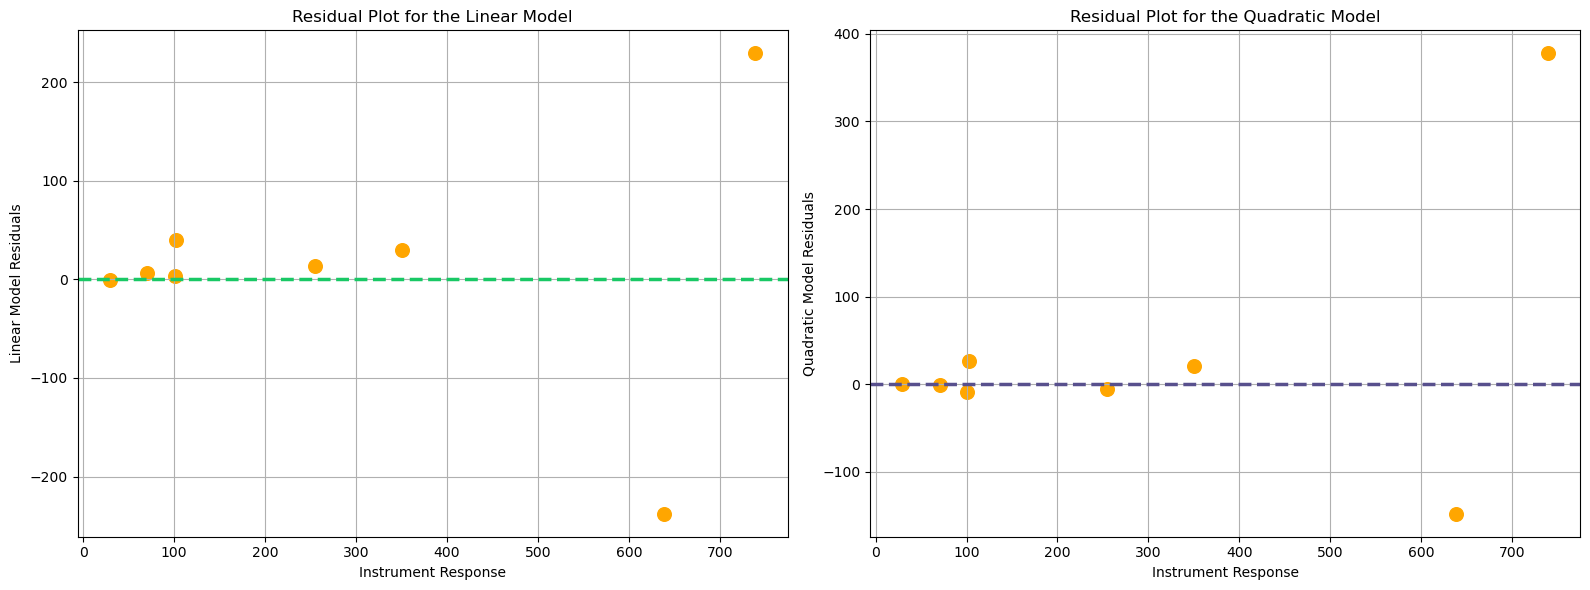

In [16]:
# Calculate residuals
pol1_residuals_r = y_r - result_r1.eval()
pol2_residuals_r = y_r - result_r2.eval()

# Create a 2x2 subplot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

# Plot the calibration curve
ax1 = axes[0]
ax1.scatter(x_r, pol1_residuals_r, color='#ffa600', s=96)
ax1.axhline(y=0, color='#19c865', linestyle='--', linewidth=2.5)
ax1.set_xlabel('Instrument Response')
ax1.set_ylabel('Linear Model Residuals')
ax1.set_title('Residual Plot for the Linear Model')
ax1.grid(True)

# Plot residuals
ax2 = axes[1]
ax2.scatter(x_r, pol2_residuals_r, color='#ffa600', s=96)
ax2.axhline(y=0, color='#58508d', linestyle='--', linewidth=2.5)
ax2.set_xlabel('Instrument Response')
ax2.set_ylabel('Quadratic Model Residuals')
ax2.set_title('Residual Plot for the Quadratic Model')
ax2.grid(True)

plt.tight_layout()
plt.show()

### The residual plots for both mappings of the variables shows an increase in variability as the energy increases.

_ _ _
* The predictive capacity of the model might be affected by the incrsease in variance when measuring high energy gamma-rays. 

* The Cs137 source used throughout the rest of this experiment seems to be the best option for a high-energy source based on the quadratic fit of the reversed mapping.

* As the angular scattering will produce weaker responses it can be assumed that the quadratic model will perform quite well at predicting the scattered energies.   

_ _ _

## Author
** **

### <a href="https://www.linkedin.com/in/alin-airinei/">Alin Airinei</a>